# Memory Information

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.90GB
Used: 540.47MB
Percentage: 6.2%


In [ ]:
! nvidia-smi

Fri Jul 23 03:33:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Module Imports

In [ ]:
!pip install -qq git+https://github.com/albumentations-team/albumentations
!pip install -qq torch-lr-finder

In [ ]:
!git clone -qq https://github.com/ikshana-ai/ikshana -b OneCycle ./temp
!cp -r ./temp/src/ikshana/ ./ikshana
!rm -r temp

In [ ]:
from ikshana.data.pytorch_data import GetData
from ikshana.data.transformations import * #HELPER, generate_compose
from ikshana.visualization import plot_inference, plotter

ModuleNotFoundError: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import matplotlib.pyplot as plt

# Data

## Finding Data Stats

In [ ]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")

LOADER_kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

In [ ]:
cifar = GetData('CIFAR10')

In [ ]:
train_data = cifar.build_data(train=True)
test_data = cifar.build_data(train=False)


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [ ]:
loader = DataLoader(
    train_data,
    batch_size=1000,
    num_workers=1,
    shuffle=False
)

mean, std = plotter.data_stats(loader)

Train Statistics
Image Shape:  torch.Size([3, 32, 32])
 - mean: tensor([0.4914, 0.4822, 0.4465])
 - std: tensor([0.2470, 0.2434, 0.2615])


## Creating Augmentations for Data

In [ ]:
import albumentations as A

In [ ]:
import cv2
transformations = {
    'Sequential': {
                    'PadIfNeeded': {'min_height': 40, 'min_width': 40, 'border_mode': cv2.BORDER_CONSTANT,
                                    'value': mean.tolist()},
                    'RandomCrop': {'height': 32, 'width': 32, 'p': 1},
                    'p': 1
                },
    'HorizontalFlip': {'p':0.6}, #FlipLR
    'CoarseDropout': {'max_holes': 1, 'max_height':16, 'max_width':16, 'min_holes': 1, 
                      'min_height':16, 'min_width':16, 'fill_value': mean.tolist(), 
                      'mask_fill_value': None}
}

In [ ]:
train_trans = generate_compose(mean, std, **transformations) # Normalize and ToTensor by Default along with Transformations
test_trans = generate_compose(mean, std) # Normalize and ToTensor by Default. No other Transformations

In [ ]:
train_data = cifar.build_data(train_trans, train=True)
test_data = cifar.build_data(test_trans, train=False)
train_loader = cifar.build_loader(train_data, 512, **LOADER_kwargs)
test_loader = cifar.build_loader(test_data, 512, **LOADER_kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = train_data.classes
print(classes)

### Training Data

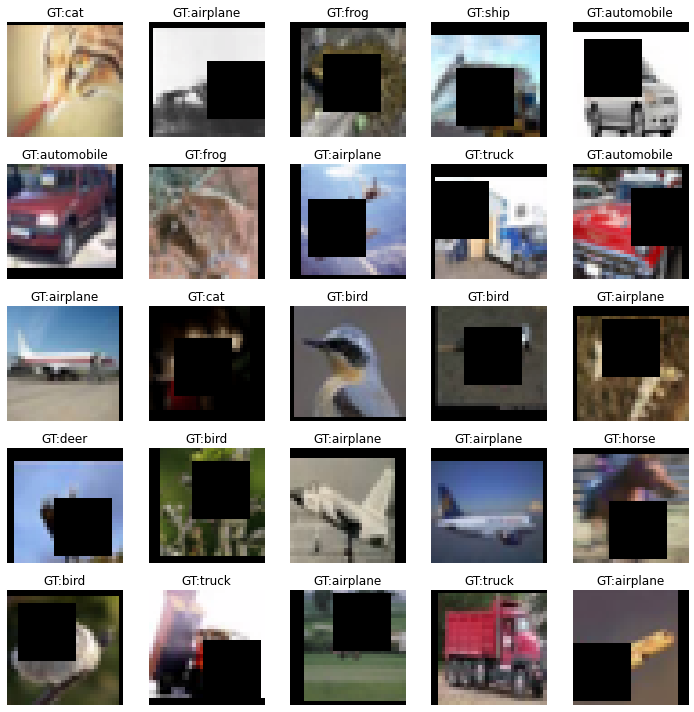

In [ ]:
from ikshana.visualization import plot_inference, plotter
plotter.plot_data_grid(train_loader, mean= mean, std= std, class_list=classes, ncol=5,nrow=5)

### Test Data

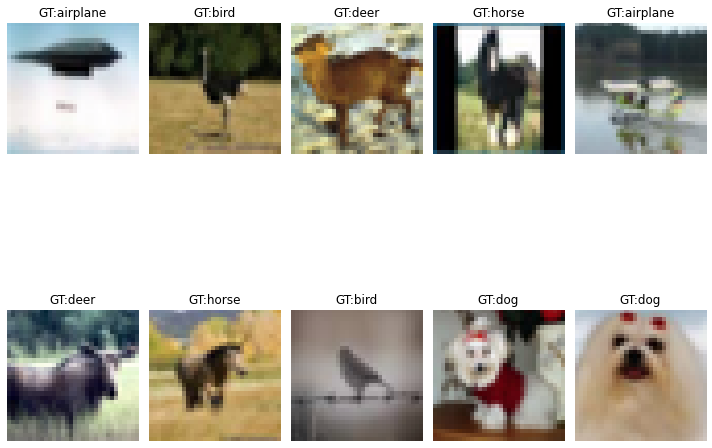

In [ ]:
plotter.plot_data_grid(test_loader, mean= mean, std= std, class_list=classes, ncol=5,nrow=2)

# Model

In [ ]:
from ikshana.models.CIFAR10.multiAdd import Net

In [ ]:
model = Net().to(DEVICE)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       WeirdBlock-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# LR Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.31E-03


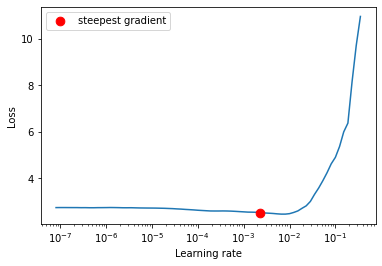

In [ ]:
from torch_lr_finder import LRFinder

model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=1e-10, momentum=0.9)
criterion = nn.NLLLoss()

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
from ikshana.features.runner import run

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
#model = Net().to(DEVICE)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.05, epochs=24, steps_per_epoch=len(train_loader), 
                       pct_start=5/24, div_factor=100, final_div_factor=1) #No Annealing
ai = run.Run(model, train_loader, test_loader, 25, DEVICE, optimizer, scheduler)
ai()

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1


loss=1.627498984336853 batch_id=97: 100%|██████████| 98/98 [00:22<00:00,  4.34it/s]


TRAIN set: Average loss: 1.9032, Train Accuracy: 31.30% | TEST set: Average loss: 1.4918, Test Accuracy: 48.17%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 1.5407, Train Accuracy: 47.50% | TEST set: Average loss: 1.4842, Test Accuracy: 53.35%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 1.2912, Train Accuracy: 57.84% | TEST set: Average loss: 1.5802, Test Accuracy: 60.79%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 1.2222, Train Accuracy: 62.01% | TEST set: Average loss: 1.6686, Test Accuracy: 62.65%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.9315, Train Accuracy: 69.43% | TEST set: Average loss: 1.0697, Test Accuracy: 72.49%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.8016, Train Accuracy: 73.56% | TEST set: Average loss: 0.7120, 

In [ ]:
print('Train Accuracy:', max(ai.metrics['train_accuracy']))
print('Test Accuracy:', max(ai.metrics['test_accuracy']))

Train Accuracy: 93.172
Test Accuracy: 91.24


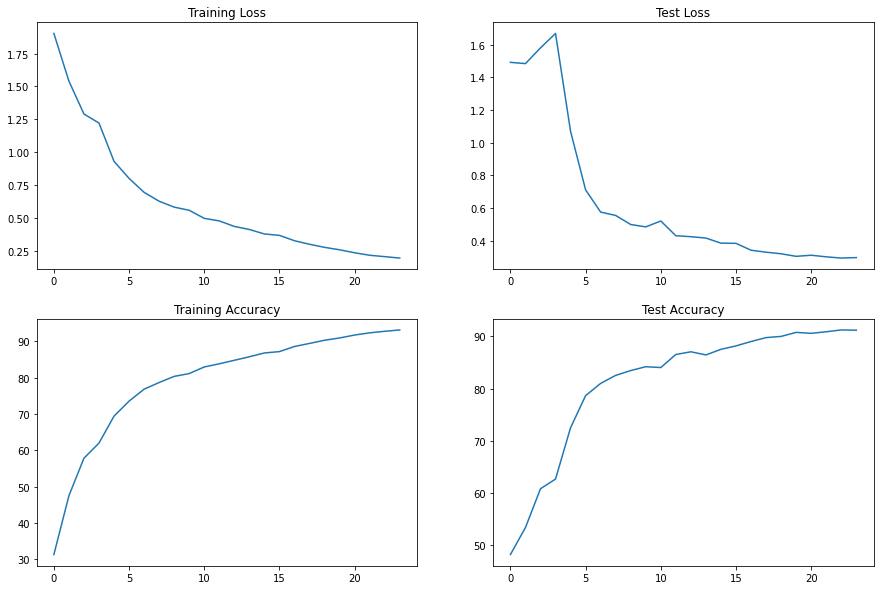

In [ ]:
plotter.plot_loss_acc(ai.metrics['train_loss'], ai.metrics['train_accuracy'], ai.metrics['test_loss'], ai.metrics['test_accuracy'])

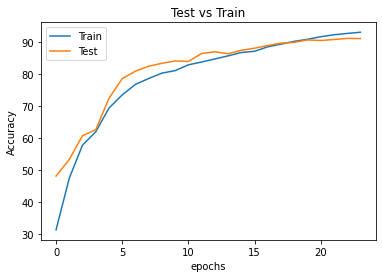

In [ ]:
plotter.plot_combined([ai.metrics['train_accuracy'], ai.metrics['test_accuracy']])

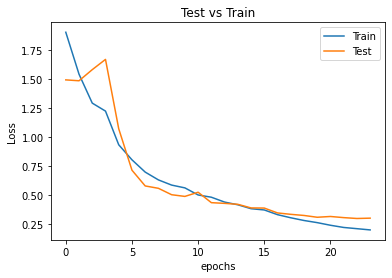

In [ ]:
plotter.plot_combined([ai.metrics['train_loss'], ai.metrics['test_loss']], y_label='Loss')

In [ ]:
from ikshana.visualization import plot_inference, plotter
results = plot_inference.Results(model, test_loader, DEVICE, mean, std, classes)

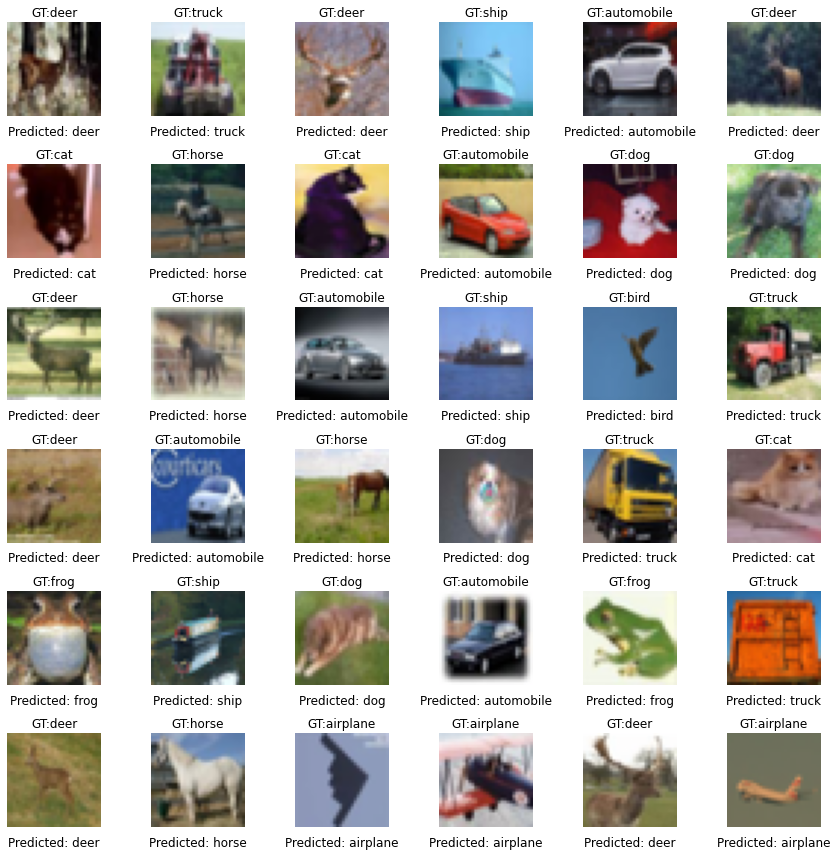

In [ ]:
results.plot_batch(ncol=6,nrow=6, figsize=(12,12))

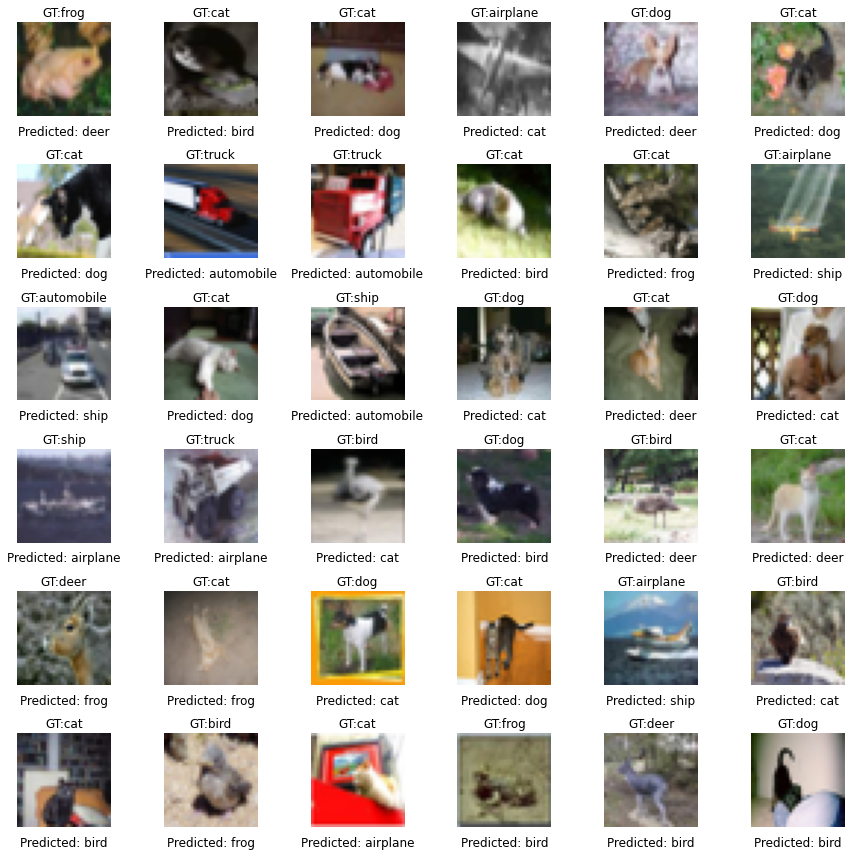

In [ ]:
results.plot_incorrect(ncol=6,nrow=6, figsize=(12,12))

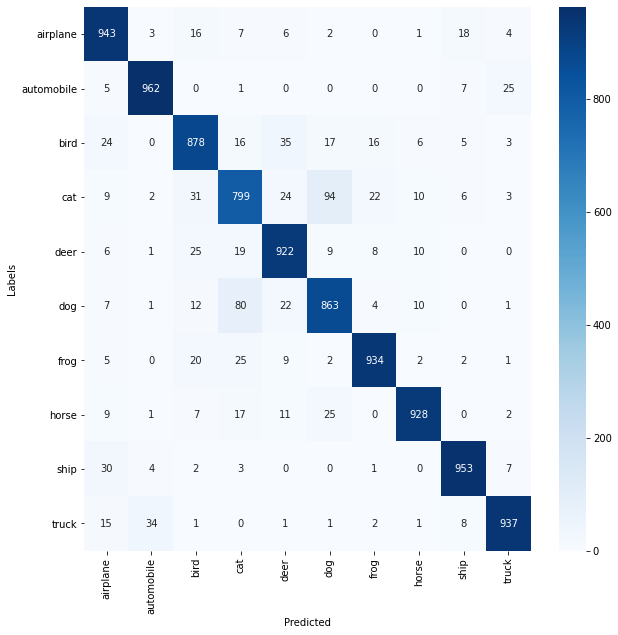

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class cat is 79.90
Accuracy of class dog is 86.30
Accuracy of class bird is 87.80
Accuracy of class deer is 92.20
Accuracy of class horse is 92.80
Accuracy of class frog is 93.40
Accuracy of class truck is 93.70
Accuracy of class airplane is 94.30
Accuracy of class ship is 95.30
Accuracy of class automobile is 96.20


In [ ]:
results.class_accuracy(figsize=(10,10))